In [1]:
import torch
from refactor.probes import model_setup

In [2]:
model_names = ["gpt_gptsw3_en_da_356m_gbs1024","gpt_gptsw3_en_da_is_356m_gbs1024","gpt_gptsw3_en_is_da_356m_gbs1024","gpt_sw3_356m"]
lambda_val = 5
layer = "transformer.h.15.ln_1.bias"
for model_name in model_names:
    
    model_path = "downloaded_models/"

    model, tokenizer, device = model_setup(f"{model_path}{model_name}")
    
    steering = torch.load(f"steering_vectors/{model_name}/combined_steering_vector_layer_15_tensor.pt",map_location = device)
    
    model.state_dict()[layer] += steering*lambda_val
    
    model.save_pretrained(f'{model_path}/{model_name}_with_steering_lambda_{lambda_val}')
    tokenizer.save_pretrained(f'{model_path}/{model_name}_with_steering_lambda_{lambda_val}')  # Optional but recommended

found device: cpu


/var/folders/p0/267bnxr16cq2xpr1crtpxbgw0000gn/T/ipykernel_4552/1524319005.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  steering = torch.load(f"steering_vectors/{mod

found device: cpu


/var/folders/p0/267bnxr16cq2xpr1crtpxbgw0000gn/T/ipykernel_4552/1524319005.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  steering = torch.load(f"steering_vectors/{mod

found device: cpu


/var/folders/p0/267bnxr16cq2xpr1crtpxbgw0000gn/T/ipykernel_4552/1524319005.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  steering = torch.load(f"steering_vectors/{mod

found device: cpu


/var/folders/p0/267bnxr16cq2xpr1crtpxbgw0000gn/T/ipykernel_4552/1524319005.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  steering = torch.load(f"steering_vectors/{mod

In [94]:
import pandas as pd
from matplotlib import pyplot as plt
df = pd.read_csv("results/data/steering_data_bible/bible_data_combined.csv")
df = df[(df.layer == 15) & (df.lambda_amount == 5)]
#temp =pd.read_csv("rresults/data/steering_data_bible/combined_english_without_steering.csv")

In [114]:
df

,danish_predicted_output,english_predicted_output,danish_true_label,english_true_label,layer,lambda_amount,bible_verse,danish_prompt_score,english_prompt_score,danish_language_prediction_on_english_steered,english_predicted_output_without_steering,english_predicted_output_without_steering_score,english_score_on_danish_prompt,danish_score_on_english_prompt_without_steering
0,"Jesus, Jesus Kristus og den menneskelige ånd....",8. Dansk: Du skal ikke have for travlt. E...,"Og Jorden var øde og tom, og der var Mørke ove...",Now the earth was formless and empty. Darkness...,15,5,0,1.00,0.00,1.00,. Tindra: I think the point is that God is a...,1.0,0.0,0.0
1,\nI dag kan nogle muslimer dog ikke tro på det...,. 20 Og Gud skabte i begyndelsen himlen og jo...,"Og Jorden var øde og tom, og der var Mørke ove...",Now the earth was formless and empty. Darkness...,15,5,0,1.00,0.00,1.00,"If you think that this is the case, you're...",1.0,0.0,0.0
2,"Det var ham, der gav næring til de grønne pla...","gud var en mand, der var en mand, der var en ...","Og Gud sagde: ""Der blive Lys!"" Og der blev Lys.","God said, ""Let there be light,"" and there was ...",15,5,1,1.00,0.00,1.00,the earth was so cold and dead. the wind was ...,1.0,0.0,0.0
3,"ud af landet gik han, og hans engel gik som ...",The sky was empty. The sky was black. ...,"Og Gud sagde: ""Der blive Lys!"" Og der blev Lys.","God said, ""Let there be light,"" and there was ...",15,5,1,1.00,1.00,0.00,and there was a cold and a coldness over the ...,1.0,0.0,0.0
4,"så det altid var en lyst dag.\n""Vatikanstaten...",...,"og Gud kaldte Lyset Dag, og Mørket kaldte han ...","God called the light ""day,"" and the darkness h...",15,5,3,0.18,0.00,0.00,...,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,"men de 3. afkom, med en alder af mellem 30 — ...",Eber døde i 1939. -> Eber died in 1939. ...,"og efter at Eber havde avlet Peleg, levede han...",Eber lived four hundred thirty years after he ...,15,5,282,1.00,0.00,1.00,"His daughter, and one of the daughters of the...",1.0,0.0,0.0
564,Avlsmålet på dette tidspunkt var omkring én a...,.<|endoftext|>,"Da Peleg havde levet 30 År, avlede han Re'u;","Peleg lived thirty years, and became the fathe...",15,5,283,0.00,0.76,0.01,". He died in 1210, and was buried at St. Nicho...",1.0,0.0,0.0
565,".\n""Eber har levet 430 år og avlet sønner og d...","He was the father of the great Peleg, the gre...","Da Peleg havde levet 30 År, avlede han Re'u;","Peleg lived thirty years, and became the fathe...",15,5,283,0.16,1.00,0.00,"""Son of the Eber"" is the name of a family na...",1.0,0.0,0.0
566,men at bengalierne skulde være blotte hundeav...,.<|endoftext|>,"og efter at Peleg havde avlet Re'u, levede han...",Peleg lived two hundred nine years after he be...,15,5,284,1.00,0.76,0.01,He was born in 1878 and was the eldest of the...,1.0,0.0,0.0


In [115]:
sub = df[df.danish_prompt_score < 0.6]
for index, row in sub.iterrows():
    print(index, row.danish_predicted_output)

4  så det altid var en lyst dag.
"Vatikanstaten" har vist alle fordelene ved et sådant syn, også for dem der ser forkert
8 
Amazing that I am still here! ->
Spændende at jeg stadig er her!
The first version is a text editor.
20 
engelsk: After a while of cultivation, after planting 100-150 plums, many years later, they gave green
28  nu ser jeg dem ikke mere, og de hvide skyer deroppe, er ikke borte mere."
dansk
Tetrahedralene av
30 . -3. Mosebog 5:22. 2. Mosebog 24:6, 7. - 2.
35 
5. Engelsk: It's not the best, it's not the best, it's not the best. I said, "
41 "<|endoftext|>
47 .<|endoftext|>
49 "<|endoftext|>
52 "<|endoftext|>
59 
113171228010.01.17 11:52
LÆS OGSÅ:
61 .
For he was an all-encompassing God, and all his creation together was called God."<|endoftext|>
76 
15. maj 2011 at 12:37 · Reply
15. maj 2011 at
79  -> This created the "Mazurka" as the rivers of the Eda flowed into it, and outside the river split into four main
80 d og sølv og edelstener. -> Norsk<|endoftext|>
81 .


In [119]:
df.loc[565]

danish_predicted_output                            .\n"Eber har levet 430 år og avlet sønner og d...
english_predicted_output                            He was the father of the great Peleg, the gre...
danish_true_label                                       Da Peleg havde levet 30 År, avlede han Re'u;
english_true_label                                 Peleg lived thirty years, and became the fathe...
layer                                                                                             15
lambda_amount                                                                                      5
bible_verse                                                                                      283
danish_prompt_score                                                                             0.16
english_prompt_score                                                                             1.0
danish_language_prediction_on_english_steered                                              

In [ ]:
519  habilizare. Som du sier, skal et selskap være mer enn et sted, et firma med egen merkevare, i så fall skal dere
525  og mange av de andre var nok eldre iår. En av 50 arrene i aritmetikken var for stor til å vise opp
560  -> Da sjelen hadde fått satt eber, levde han 403 år og fikk sønner og døtre.
564  Avlsmålet på dette tidspunkt var omkring én av de to hanlene. En kjent figur i det nordiske land, er Sigurd Haakonsson saga


In [ ]:
df.loc[[519,525,560,564]].danish_predicted_output

519     habilizare. Som du sier, skal et selskap være...
525     og mange av de andre var nok eldre iår. En av...
560     -> Da sjelen hadde fått satt eber, levde han ...
565    .\n"Eber har levet 430 år og avlet sønner og d...
Name: danish_predicted_output, dtype: object

In [118]:
for row in df[df.bible_verse.isin(df.loc[[518,524,559,564]].bible_verse)].danish_true_label.unique():
    print(row)

Hadoram, Uzal, Dikla,
og deres Bosteder strækker sig fra Mesja i Retning af Sefar, Østens Bjerge.
og efter at Sjela havde avlet Eber, levede han 403 År og avlede Sønner og Døtre.
Da Peleg havde levet 30 År, avlede han Re'u;


In [72]:
good_verses = [175, 159, 201, 215, 50, 60, 123, 157, 148, 96, 227]

for verse in df[df.bible_verse.isin(good_verses)].english_true_label.unique():
    print(verse[-30:])

sed up the flesh in its place.
 husband with her, and he ate.
l became the father of Lamech.
 father of sons and daughters.
rupted their way on the earth.
r food for you, and for them."
 before me in this generation.
was lifted up above the earth.
amilies, went out of the ship.
a flood to destroy the earth."
 see their father's nakedness.


In [73]:
df.english_predicted_output_without_steering.iloc[0]

'.   Tindra: I think the point is that God is an infinitely powerful being and He is God.  The earth is not God.  It is God.<|endoftext|>'

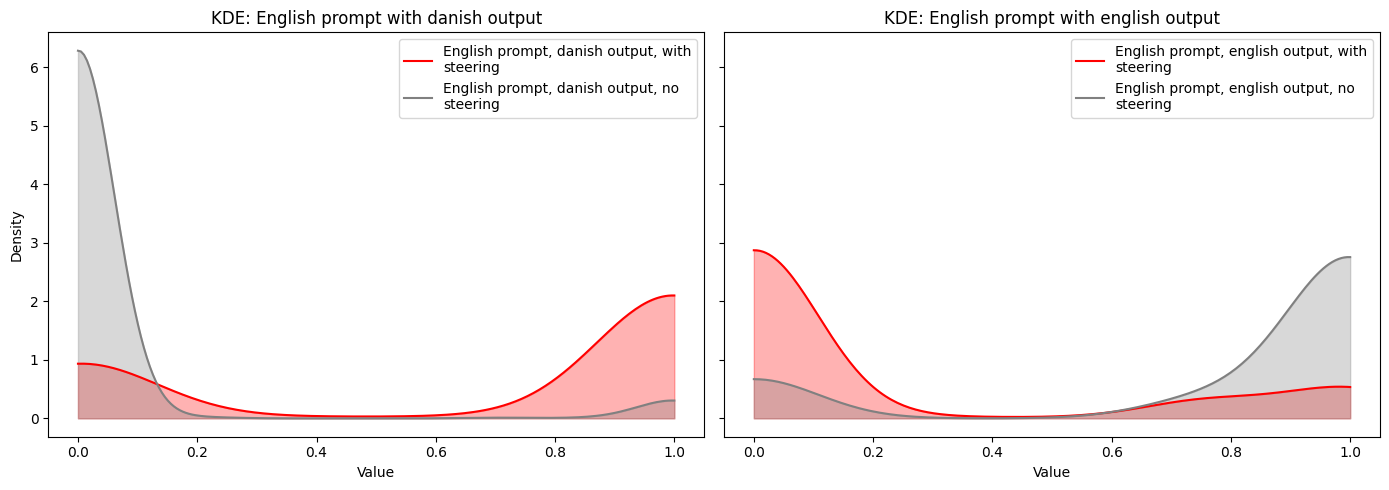

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import textwrap

# Columns for each KDE plot
kde1_cols = [
    "danish_language_prediction_on_english_steered",
    "danish_score_on_english_prompt_without_steering"
]
kde2_cols = [
    "english_prompt_score",
    "english_predicted_output_without_steering_score"
]

# Titles
titles = {
    "danish_language_prediction_on_english_steered": "English prompt, danish output, with steering",
    "danish_score_on_english_prompt_without_steering": "English prompt, danish output, no steering",

    "english_prompt_score": "English prompt, english output, with steering",
    "english_predicted_output_without_steering_score": "English prompt, english output, no steering"
}

# Color scheme using matplotlib's Set1 colormap
colors = plt.cm.Set1(range(5))
color_map = {
    "danish_language_prediction_on_english_steered": "red",
    "danish_score_on_english_prompt_without_steering": "grey",
    "english_prompt_score": "red",
    "english_predicted_output_without_steering_score": "grey",
}

#Farve 1 english_predicted_output_without_steering_score

# Create 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Function to plot KDE
def plot_kde(ax, cols):
    for col in cols:
        data = df[col].dropna()
        if len(data) == 0:
            continue  # Skip empty columns
        kde = gaussian_kde(data)
        x_vals = np.linspace(min(data), max(data), 200)
        y_vals = kde(x_vals)
        ax.plot(x_vals, y_vals, label="\n".join(textwrap.wrap(titles[col], width=40)), color=color_map[col])
        ax.fill_between(x_vals, y_vals, alpha=0.3, color=color_map[col])

# Plot 1
plot_kde(axes[0], kde1_cols)
axes[0].set_title("KDE: English prompt with danish output")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Density")
axes[0].legend()

# Plot 2
plot_kde(axes[1], kde2_cols)
axes[1].set_title("KDE: English prompt with english output")
axes[1].set_xlabel("Value")
axes[1].legend()

plt.tight_layout()
plt.show()


In [88]:
sample = df[df.danish_language_prediction_on_english_steered < 0.6].sample(10)
sample

,danish_predicted_output,english_predicted_output,danish_true_label,english_true_label,layer,lambda_amount,bible_verse,danish_prompt_score,english_prompt_score,danish_language_prediction_on_english_steered,english_predicted_output_without_steering,english_predicted_output_without_steering_score,english_score_on_danish_prompt,danish_score_on_english_prompt_without_steering
193,k.<|endoftext|>,lamech became the father of ammuel. ammuel be...,"Lemek tog sig to Hustruer; den ene hed Ada, de...",Lamech took two wives: the name of the one was...,15,5,97,0.01,1.00,0.00,lamech became the father of nimrod. nimrod be...,1.00,0.75,0.00
367,"så tog gud sig i var med jorden, så vandet sa...",The Ark of the Covenant. The Ark of the Cov...,Verdensdybets Kilder og Himmelens Sluser lukke...,The deep's fountains and the sky's windows wer...,15,5,184,1.00,1.00,0.00,"and the earth rose up again, and the ark was ...",1.00,0.00,0.00
21,"Så da Adam hørte dette, kom der en vis fred o...","11,10-12. 11,10. 11,10. 11,10. 11,10. 1...","Og det blev Aften, og det blev Morgen, tredje ...","There was evening and there was morning, a thi...",15,5,11,1.00,0.00,0.00,10 The children of the children of the chil...,1.00,0.00,0.00
511,"De tre første har samme navn, og alle har bet...","The children of shem, the sons of elam, as...","Arams Sønner: Uz, Hul, Geter og Masj.","The sons of Aram: Uz, Hul, Gether, and Mash.",15,5,256,0.00,1.00,0.00,"Beyond the name of shem, the king of Ashdod ...",1.00,0.00,0.00
212,"\nModeren skabte han som et menneske, der skul...",.<|endoftext|>,"Da Adam havde levet i 130 År, avlede han en Sø...","Adam lived one hundred thirty years, and becam...",15,5,107,1.00,0.76,0.01,"""And the angel of the LORD spoke to me, sayi...",1.00,0.00,0.00
285,. Derfor er det en så stor bedrift for mig at ...,.<|endoftext|>,"Og HERREN sagde: ""Jeg vil udslette Menneskene,...","Yahweh said, ""I will destroy man whom I have c...",15,5,143,1.00,0.76,0.01,"He said, ""The Lord God has made me. I am a hu...",1.00,0.00,0.00
510,Til gengæld havde hans far sat en pris for si...,.<|endoftext|>,"Arams Sønner: Uz, Hul, Geter og Masj.","The sons of Aram: Uz, Hul, Gether, and Mash.",15,5,256,1.00,0.76,0.01,.<|endoftext|>,0.76,0.00,0.01
50,i guds billede skabte han jorden og mennesket...,. <|endoftext|>,"og Gud velsignede dem, og Gud sagde til dem: ""...","God blessed them. God said to them, ""Be fruitf...",15,5,26,1.00,0.00,0.00,"In the Bible God created men and women, an...",1.00,0.00,0.00
501,"o.s.v. Ja, der var ganske mange. Men denne st...","the josia, the joseph, the josephine, and the...","Arvaditerne, Zemariterne og Hamatiterne; men s...","the Arvadite, the Zemarite, and the Hamathite....",15,5,251,0.99,0.99,0.01,"the fong, the gab, the gob, the gob, the gob,...",1.00,0.00,0.00
111,"\nDyret med den tykke hals, som en østeuropæis...","""I know,"" said the woman. ""But I said, 'You...","Kvinden svarede: ""Vi har Lov at spise af Frugt...","The woman said to the serpent, ""Of the fruit o...",15,5,56,1.00,1.00,0.00,"""No,"" said the woman, ""the tree of the garde...",1.00,0.00,0.00


In [89]:
for row in df[df.danish_language_prediction_on_english_steered < 0.6].english_predicted_output:
    print(row)

    The sky was empty.    The sky was black.    The sky was grey.    The sky was black.    The sky variously glowed.    The sky variously glowed.    The sky variously glowed.    The sky variously glowed.    The sky
                                                                                                                                                                
    the light was always "night," but when he called it "day," it was "morning."    this is why viz. the sun is always "night," and the moon is always "day."    så hvordan skal man så forklare at det altid er mørkt i nat?    det er det jo ikke, men det er jo
"<|endoftext|>
.    decrease<|endoftext|>
                                                                                                                                              
  I'm not sure, and I'm not sure, if you can still call this a god. It is, in fact, the same god, for the earth, someday, vile, ogre-like, and jeg-elsker-mig-selv-til-d
      Deute

In [40]:
sample[["bible_verse","english_predicted_output"]]

,bible_verse,english_predicted_output
313,157,". 8 Og han tog af alle de fugle, som var i sl..."
555,278,"dansk: Vi har brug for en ny, bæredygtig r..."
533,267,". Dette er det, der er i sproget og i tale.<|..."
295,148,". Det er ingen tvivl om, at Gud før skabte ve..."
107,54,12. Og det er en god ide at overveje. -> It...
190,96,". enoch blev født i en by, og han kaldte den ..."
200,101,". danish: I 1899, efter at være blevet mor t..."
183,92,. I am greater than you. Jeg er større end jer...
253,127,"10. dansk: De vil ikke have, at jeg skal kom..."
452,227,". ""Mine,"" sagde han til sin fader, ""der var e..."


In [30]:
sample.english_true_label.iloc[-1]

'Canaan became the father of Sidon (his firstborn), Heth,'

In [46]:
sample

,danish_predicted_output,english_predicted_output,danish_true_label,english_true_label,layer,lambda_amount,bible_verse,danish_prompt_score,english_prompt_score,danish_language_prediction_on_english_steered,english_predicted_output_without_steering,english_predicted_output_without_steering_score,english_score_on_danish_prompt,danish_score_on_english_prompt_without_steering
313,"\nAnd when the waters stand high with the sun,...",". 8 Og han tog af alle de fugle, som var i sl...",Og du skal indsamle et Forråd af alle Slags Le...,"Take with you of all food that is eaten, and g...",15,5,157,0.00,0.0,1.0,"But if you do not come to me, I will send you...",1.00,1.0,0.00
555,"og han har derfor ikke blot en sjæls liv, men...","dansk: Vi har brug for en ny, bæredygtig r...","og efter at Arpaksjad havde avlet Sjela, leved...",Arpachshad lived four hundred three years afte...,15,5,278,0.74,0.0,1.0,The shelah were the most popular of the Arab...,1.00,0.0,0.00
533,\nLighed i sprog.\nI forbindelse med dette emn...,". Dette er det, der er i sproget og i tale.<|...","Da de nu drog østerpå, traf de på en Dal i Sin...","It happened, as they traveled east, that they ...",15,5,267,1.00,0.0,1.0,"13. ""Det er et fantastisk sted at spise."" ...",0.03,0.0,0.97
295,"for Guds ansigt er retfærdigt,\n2. Jeg hørte ...",". Det er ingen tvivl om, at Gud før skabte ve...","og Gud så til Jorden, og se, den var fordærvet...","God saw the earth, and saw that it was corrupt...",15,5,148,1.00,0.0,1.0,"The bible says, ""He is the God of the eart...",1.00,0.0,0.00
107,\nDansk\nDaphna och Doron: Döden från den döda...,12. Og det er en god ide at overveje. -> It...,"Og de var begge nøgne, både Adam og hans Hustr...","They were both naked, the man and his wife, an...",15,5,54,0.00,0.0,1.0,. 4 Og en mann vil forlate sin far og sin mor...,0.00,0.0,0.00
190,"og kongen sagde: ""hanok er der, som ikke kjen...",". enoch blev født i en by, og han kaldte den ...",Hanok fik en Søn Irad; Irad avlede Mehujael; M...,To Enoch was born Irad. Irad became the father...,15,5,96,0.92,0.0,1.0,the city was called cain. enoch was a good ma...,1.00,0.0,0.00
200,hun har givet han navn efter en gammel konge....,". danish: I 1899, efter at være blevet mor t...","Og Lemelk sagde til sine Hustruer: ""Ada og Zil...","Lamech said to his wives, ""Adah and Zillah, he...",15,5,101,1.00,0.0,1.0,the three sisters were sisters of a different...,1.00,0.0,0.00
183,"; men jeg vil velsigne dig.""<|endoftext|>",. I am greater than you. Jeg er større end jer...,"når du nu jager mig bort fra Agerjorden, og je...","Behold, you have driven me out this day from t...",15,5,92,0.49,0.0,1.0,12. Svenska: Såsom framgår av det ovan anf...,0.00,0.0,0.00
253,han døde den 9 oktober 700 år gammel og blev ...,"10. dansk: De vil ikke have, at jeg skal kom...",således blev Enoks fulde Levetid 365 År;,All the days of Enoch were three hundred sixty...,15,5,127,1.00,0.0,1.0,"In 1984, the Bible said that there were 135,...",1.00,0.0,0.00
452,så gik de i stor angst og sagde til ham: Herr...,". ""Mine,"" sagde han til sin fader, ""der var e...","men Sem og Jafet tog Kappen, lagde den på dere...","Shem and Japheth took a garment, and laid it o...",15,5,227,1.00,0.0,1.0,"""My lord, the canaan is naked."" ""My lord,"" s...",1.00,0.0,0.00


In [57]:
sample.iloc[3]

danish_predicted_output                            \nSvenska: 20. Och när nu HERREN har låtit min...
english_predicted_output                               10. dansk: Hvis du ønsker at lære mere om ...
danish_true_label                                  Men jeg vil oprette min Pagt med dig. Du skal ...
english_true_label                                 But I will establish my covenant with you. You...
layer                                                                                             15
lambda_amount                                                                                      5
bible_verse                                                                                      154
danish_prompt_score                                                                              0.0
english_prompt_score                                                                             0.0
danish_language_prediction_on_english_steered                                              

In [50]:
for text in sample.english_predicted_output:
    print(text)

.  20:44 Men Uz, Hul, Gethher, og Mash;<|endoftext|>
 ->  13Da hørte de lyden af HERRENs, Israels Guds, Røst, og de skjulte sig for HERRENs, Israels Guds, Åsyn blandt Træerne i Hagen.    8. And the following statement is a good example of how to handle
    3. Dansk: Jeg vil ikke anbefale dig at bruge en gratis VPN.  Engelsk: I wouldn't recommend you to use a free VPN.    4. Dansk: Jeg har været i Frankrig, i Italien, i England, i Belgien, i Tyskland og Belgien, hvor jeg mødte en fransk kvinde.  Engelsk: I have been in France, in Italy, in
    10. dansk: Hvis du ønsker at lære mere om denne proces, så klik her.  engelsk: If you want to learn more about this process, please click here.    11. dansk: Men når jeg ser på det fra en anden vinkel, ser jeg, at det er
 14 Deborah sagde til David: "Du skal bygge dig et alter til Herren, for at han kan ære dig; for han er en Gud, der ikke vil svigte sin elskede." 15 Og David sagde til ham: "Herre! vil du da ikke, at jeg skal tage al
  14:11 Og nu

In [32]:
sample.iloc[0:10].english_true_label.iloc[5]

'He said, "Canaan is cursed. He will be servant of servants to his brothers."'

In [34]:
sample.english_predicted_output_without_steering.iloc[-1]

' In 286 BC, in the first year of the reign of Antiochus III Palaiologos, he defeated the Phoenicians in a campaign in the Aegean. In 284 BC, he defeated the Persians in a campaign in the western part of the Aegean. In 283 BC, he defeated the Persians'

In [15]:
loc_rows = 456

In [45]:
df.loc[456].english_predicted_output

'  "I\'m sorry," Noah said. "I\'m not going to lie, but I\'m glad you\'re okay. I\'m glad for you, Noah. I\'m glad for you, Isaac."  Isaac\'s øjne var klare og stærke, og han så ud til at være ved godt mod.  "Okay, så," sagde Noah, og han'

In [19]:
df.loc[0]

danish_predicted_output                             Jesus, Jesus Kristus og den menneskelige ånd....
english_predicted_output                               8. Dansk: Du skal ikke have for travlt.  E...
danish_true_label                                  Og Jorden var øde og tom, og der var Mørke ove...
english_true_label                                 Now the earth was formless and empty. Darkness...
layer                                                                                             15
lambda_amount                                                                                      5
bible_verse                                                                                        0
danish_prompt_score                                                                              1.0
english_prompt_score                                                                             0.0
danish_language_prediction_on_english_steered                                              

In [17]:
df[df.english_prompt_score < 0.6].sample(10)["english_predicted_output"]

18567      13. dansk: Dette gælder også for produkter, ...
34119    " på Dansk.  Den tredje gang sagde Gud til Ada...
14031                                                  ...
39159        For en kort tid, er det kun de to børn, so...
41799        Engelsk: "November 1984" er en serie af 12...
36999     og hver fugl på himlen, og bragt dem til mand...
11703        20. 30% af de danske børn får nemlig deres...
42687        TIL    1. Den Hellige Ånd er den eneste sa...
40479     de havde to små børn. de havde ingen penge. d...
47247    . ->  engelsk  Og da sagde Herren til Moses: S...
Name: english_predicted_output, dtype: object

In [63]:
df[df.danish_language_prediction_on_english_steered > 0.7].sample(10).english_predicted_output.iloc[0]

'    18. På den anden side er den ikke lige så god som sin forgænger. ->  On den anden side er den ikke lige så god som forgængeren.    19. Du kan ikke bruge din egen hånd til at gøre det, men med en hånd, kan du være i stand til at gøre det, som du ønsker. ->  Du kan ikke bruge din egen'